In [1]:
import pyomo.environ as oe
import pandas as pd
from pyomo.opt import SolverFactory
from subproblem_model import build_subproblem_model
from subproblem_dataloader import DataLoader

In [2]:
data = DataLoader()

In [3]:
#display(data.BMPGRPING)
#display(data.BMPGRPING)

In [54]:
# Note that there is no need to call create_instance on a ConcreteModel
mdl = build_subproblem_model(pltnts=data.PLTNTS,
                             lrsegs=data.LRSEGS,
                             bmps=data.BMPS,
                             bmpgrps=data.BMPGRPS,
                             bmpgrping=data.BMPGRPING,
                             loadsrcs=data.LOADSRCS,
                             bmpsrclinks=data.BMPSRCLINKS,
                             bmpgrpsrclinks=data.BMPGRPSRCLINKS,
                             c=data.c,
                             e=data.E,
                             tau=data.tau,
                             phi=data.phi,
                             t=data.T)

In [58]:
for l in mdl.LRSEGS:
    for p in mdl.PLTNTS:
        print('%s: %d' % (mdl.tau[l,p], mdl.tau[l,p].value))

tau[N51133RL0_6450_0000,S]: 7
tau[N51133RL0_6450_0000,P]: 7
tau[N51133RL0_6450_0000,N]: 7


In [59]:
solver = SolverFactory("minos")
results = solver.solve(mdl, tee=True, symbolic_solver_labels=True)

print('Objective is:')
print(mdl.Total_Cost())

# print(results)

MINOS 5.51Objective is:
842698.0544321468


In [60]:
for l in mdl.LRSEGS:
    for p in mdl.PLTNTS:
        print('%s: %d' % (mdl.TargetPercentReduction[l,p], oe.value(mdl.TargetPercentReduction[l,p].body)))

TargetPercentReduction[N51133RL0_6450_0000,S]: 45
TargetPercentReduction[N51133RL0_6450_0000,P]: 7
TargetPercentReduction[N51133RL0_6450_0000,N]: 7


In [32]:
# Extract just the nonzero optimal variable values
tol = 1e-6
nzvarnames = []
nzvarvalus = []
for k in mdl.x.keys():
    if (not not mdl.x[k].value):
        if abs(mdl.x[k].value)>tol:
            nzvarnames.append(mdl.x[k].getname())
            nzvarvalus.append(mdl.x[k].value)
            
# Repeat the same thing, but make a DataFrame
nonzerokeyvals_df = pd.DataFrame([[k, mdl.x[k].value]
                                  for k in mdl.x.keys()
                                  if (not not mdl.x[k].value) 
                                  if abs(mdl.x[k].value)>tol],
                                 columns=['key', 'value'])
# display(nonzerokeyvals_df.head(2))

nonzerodf = pd.DataFrame.from_dict([{'bmpshortname':x[0],
                                     'landriversegment':x[1],
                                     'loadsource': x[2],
                                     'acres': y}
                                    for x, y in zip(nonzerokeyvals_df.key, nonzerokeyvals_df.value)])
# display(nonzerodf.head(2))

In [33]:
# # Other ways to access the optimal values:
# mdl.x['HRTill', 'N51133RL0_6450_0000', 'oac'].value
#
# tol = 1e-6
# for b in mdl.BMPS:
#     for lmbda in mdl.LOADSRCS:
#         bval = mdl.x[b, 'N51133RL0_6450_0000', lmbda].value
#         if not not bval:
#             if abs(bval)>tol:
#                 print('(%s, %s): %d' % (b, lmbda, bval))

In [34]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Danny/anaconda3/envs/jupytering/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [35]:
# from matplotlib import pyplot as plt
# # barh(range(len(res)),res.values(), align='center')
# fig = plt.figure(figsize=(10, 4))
# rects = plt.barh(y=nzvarnames, width=nzvarvalus)
# ax = plt.gca()
# # ax.tick_params(axis='x', colors='white')

In [36]:
# add cost/unit data to results table
costsubtbl = data.costsubtbl
# Retain only those costs pertaining to bmps in our set
includecols = ['totalannualizedcostperunit', 'bmpshortname']
nonzerodf = nonzerodf.merge(costsubtbl.loc[:,includecols])
display(nonzerodf.head(2))

# Add total cost of each BMP to results table for this instance
nonzerodf['totalinstancecost'] = np.multiply(nonzerodf['totalannualizedcostperunit'].values,
                                             nonzerodf['acres'].values)
display(nonzerodf.head(2))
coststrs = [str(x) for x in zip(list(nonzerodf['totalannualizedcostperunit']),
                                list(nonzerodf['totalinstancecost']))]
# display(coststrs)

,acres,bmpshortname,landriversegment,loadsource,totalannualizedcostperunit
0,18.467817,HRTill,N51133RL0_6450_0000,scl,0.0
1,149.786346,HRTill,N51133RL0_6450_0000,sgg,0.0


,acres,bmpshortname,landriversegment,loadsource,totalannualizedcostperunit,totalinstancecost
0,18.467817,HRTill,N51133RL0_6450_0000,scl,0.0,0.0
1,149.786346,HRTill,N51133RL0_6450_0000,sgg,0.0,0.0


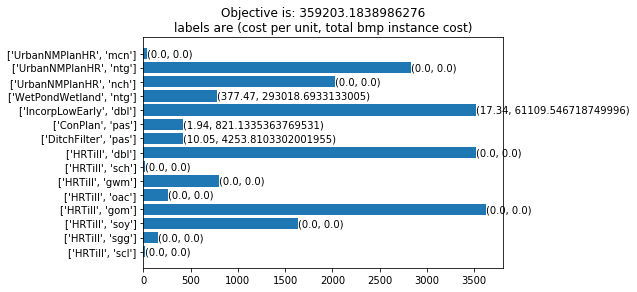

In [39]:
from datetime import datetime
keystrs = [str([x, y]) for x, y in zip(nonzerodf['bmpshortname'], nonzerodf['loadsource'])]

# Make Figure
fig = plt.figure(figsize=(10, 4))
rects = plt.barh(y=keystrs, width=nonzerodf['acres'])
ax = plt.gca()

for rect, label in zip(rects, coststrs):
    width = rect.get_width()
    plt.text(width + 0.1, rect.get_y() + rect.get_height() / 2, label,
            ha='left', va='center')

objstr = ''.join(['Objective is: ', str(mdl.Total_Cost())])
labelstr = 'labels are (cost per unit, total bmp instance cost)'
plt.title('\n'.join([objstr, labelstr]))

ax.set_position([0.3,0.1,0.5,0.8])
#plt.tight_layout()


#plt.savefig(os.path.join(projectpath,''.join(['output/tau19N19P19S_minos_', datetime.now().strftime('%Y-%m-%d_%H%M%S'),'.png'])))